In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('custom')
from openqaoa.qaoa_parameters import PauliOp, Hamiltonian, QAOACircuitParams, create_qaoa_variational_params, QAOAVariationalStandardParams
from openqaoa.problems import Knapsack, MaximumCut, NumberPartition
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.devices import create_device
from openqaoa.qaoalib import dicke_wavefunction, dicke_basis

from openqaoa.optimizers import get_optimizer
from qiskit import QuantumCircuit
from openqaoa.utilities import *
from tqdm import tqdm

In [5]:
nums=list(np.random.randint(0,200,9))
# nums = [1,2,3,2,5,5]
cost_prob = NumberPartition(nums).get_pubo_problem()
cost_hamil = cost_prob.hamiltonian

In [6]:
ground_state_hamiltonian(cost_hamil)

(1.0, ['100101100', '011010011'])

In [7]:
mixer_hamil_xy = XY_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'],qubit_connectivity='full')
mixer_hamil_x = X_mixer_hamiltonian(n_qubits=cost_prob.asdict()['n'])

### Construct workflow objects

In [85]:
circuit_params = QAOACircuitParams(cost_hamil, mixer_hamil_x, p=8)

In [86]:
variate_params_clustered = create_qaoa_variational_params(circuit_params,'clustered','rand',max_std_dev = 2)
variate_params_standard = create_qaoa_variational_params(circuit_params,'standard','ramp')

In [87]:
prepend_state = None
# prepend_state = dicke_wavefunction(4,n_qubits = cost_prob.asdict()['n'])
init_hadamard = True if prepend_state is None else False

In [88]:
device = create_device('local','vectorized')
# device_qiskit = create_device('local','qiskit.statevector_simulator')
backend_obj = get_qaoa_backend(circuit_params,device,prepend_state=prepend_state,init_hadamard=init_hadamard)

In [89]:
print(backend_obj.expectation(variate_params_clustered))
print(backend_obj.expectation(variate_params_standard))

/Users/vishal/opt/anaconda3/envs/openqaoa_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vishal/opt/anaconda3/envs/openqaoa_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


34759.001281088844
39643.4795700512


## Cost Landscape plots

In [10]:
if circuit_params.p == 1 and isinstance(variate_params,QAOAVariationalStandardParams):
    sweep_betas = np.linspace(0,np.pi,50)#.round(decimals=4)
    sweep_gammas = np.linspace(0,np.pi,100)#.round(decimals=4)  In [290]:  

    x,y = sweep_betas, sweep_gammas
    cost_landscape = np.zeros((len(x),len(y)))
    for i,xi in enumerate(tqdm(x)):
        for j,yj in enumerate(y):
            variate_params.update_from_raw([xi,yj])
            cost_landscape[i,j] = backend_obj.expectation(variate_params)
else:
    print('Set p=1 to construct the cost landscape')

Set p=1 to construct the cost landscape


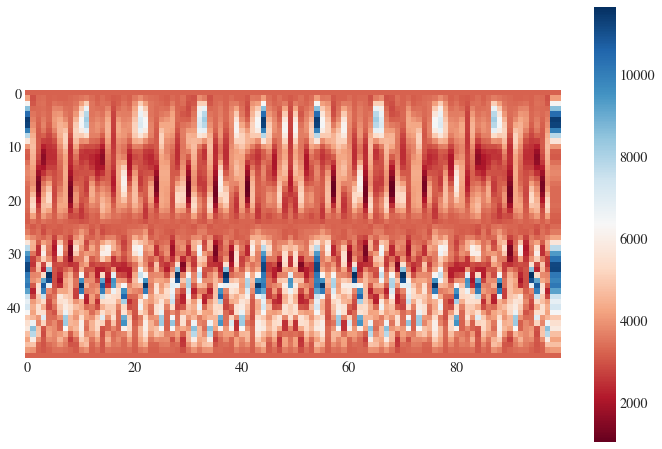

In [28]:
plt.imshow(cost_landscape,cmap='RdBu')
plt.grid(False)
plt.colorbar()

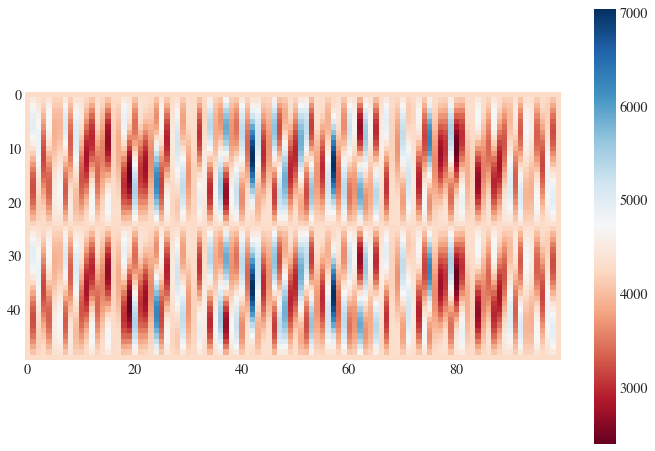

In [22]:
plt.imshow(cost_landscape,cmap='RdBu')
plt.grid(False)
plt.colorbar()

## Train the problem using an optimizer with vanilla QAOA

In [10]:
optimizer_dict = {'method': 'cobyla', 'maxiter': 6000}

In [11]:
optimizer_obj_standard = get_optimizer(backend_obj, variate_params_standard, optimizer_dict)
optimizer_obj_clustered = get_optimizer(backend_obj, variate_params_clustered, optimizer_dict)

In [12]:
optimizer_obj_standard
optimizer_obj_clustered

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAVectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 6000

In [13]:
optimizer_obj_standard()

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAVectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 6000

In [14]:
optimizer_obj_clustered()

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAVectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 6000

In [15]:
cost_history_clustered = optimizer_obj_clustered.results_information()['cost progress list']

In [16]:
cost_history_standard = optimizer_obj_standard.results_information()['cost progress list']

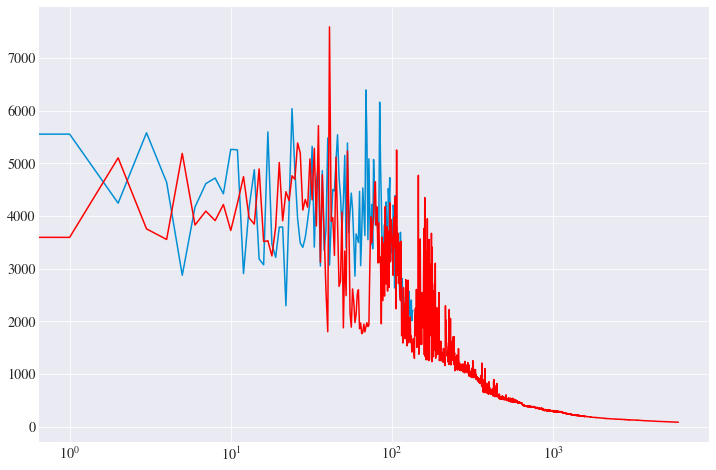

In [18]:
plt.plot(cost_history_standard)
plt.plot(cost_history_clustered, color='red')
plt.xscale('log')

In [19]:
counts_dict_clustered = optimizer_obj_clustered.results_information()['best probability']
counts_dict_standard = optimizer_obj_standard.results_information()['best probability']

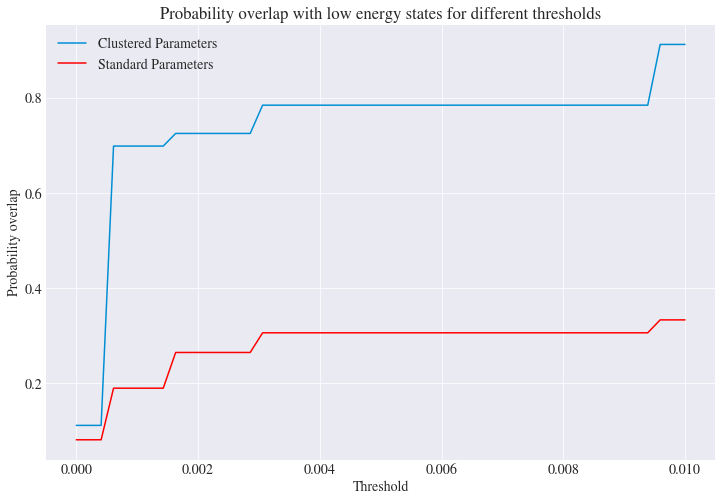

In [20]:
eps = np.linspace(0,0.01,50)
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_clustered) for ep in eps])
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_standard) for ep in eps],color='red')
plt.legend(['Clustered Parameters','Standard Parameters'])
plt.xlabel('Threshold')
plt.ylabel('Probability overlap')
plt.title('Probability overlap with low energy states for different thresholds');

In [21]:
counts_dict_standard_sorted = sort_counts_increasing_energy(cost_hamil, counts_dict_standard)
counts_dict_clustered_sorted = sort_counts_increasing_energy(cost_hamil, counts_dict_clustered)

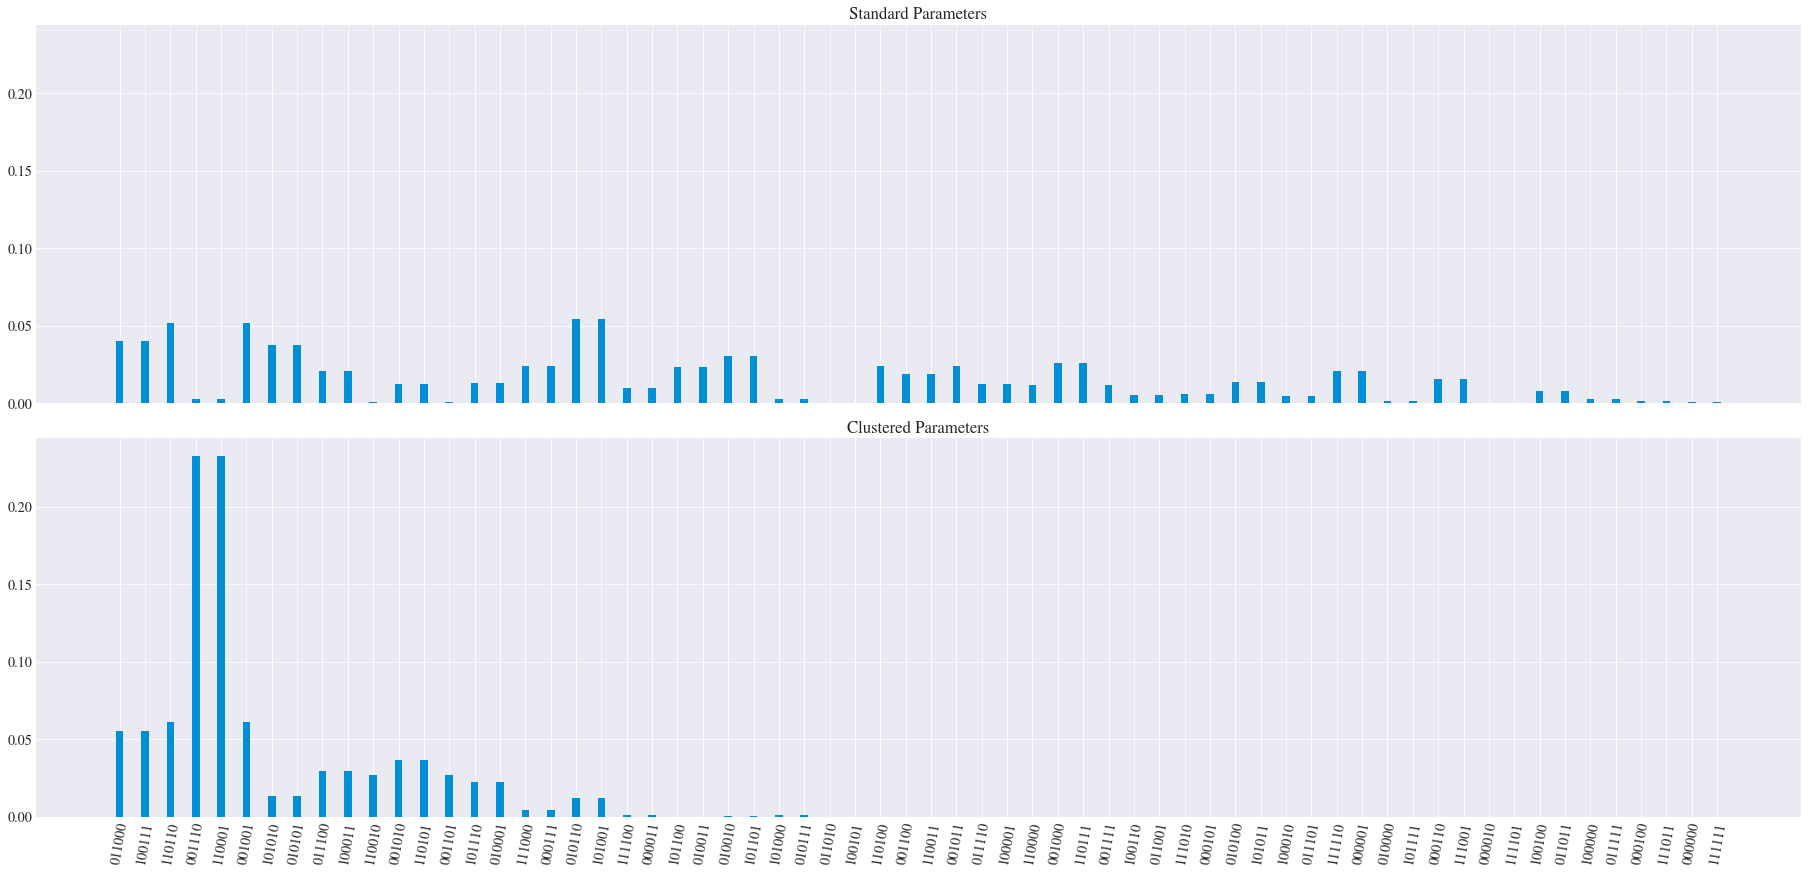

In [22]:
fig,axes = plt.subplots(2,1,figsize=(25,12),constrained_layout=True,sharey=True,sharex=True)
plot_counts(counts_dict_standard_sorted,axes[0])
plot_counts(counts_dict_clustered_sorted,axes[1])
axes[0].set_title('Standard Parameters')
axes[1].set_title('Clustered Parameters');

## Train the problem using an optimizer with XY-mixer and Dicke Wavefunction QAOA 

In [10]:
circuit_params = QAOACircuitParams(cost_hamil, mixer_hamil_xy, p=2)

In [11]:
variate_params_clustered = create_qaoa_variational_params(circuit_params,'clustered','rand',max_std_dev = 2)
variate_params_standard = create_qaoa_variational_params(circuit_params,'standard','ramp')

In [17]:
# prepend_state = None
prepend_state_4 = dicke_wavefunction(4,n_qubits = cost_prob.asdict()['n'])
prepend_state_2 = dicke_wavefunction(2,n_qubits = cost_prob.asdict()['n'])
init_hadamard = True if prepend_state is None else False

In [14]:
device = create_device('local','vectorized')
# device_qiskit = create_device('local','qiskit.statevector_simulator')
backend_obj = get_qaoa_backend(circuit_params,device,prepend_state=prepend_state,init_hadamard=init_hadamard)

In [15]:
print(backend_obj.expectation(variate_params_clustered))
print(backend_obj.expectation(variate_params_standard))

1967.6789975296706
3804.581645153524


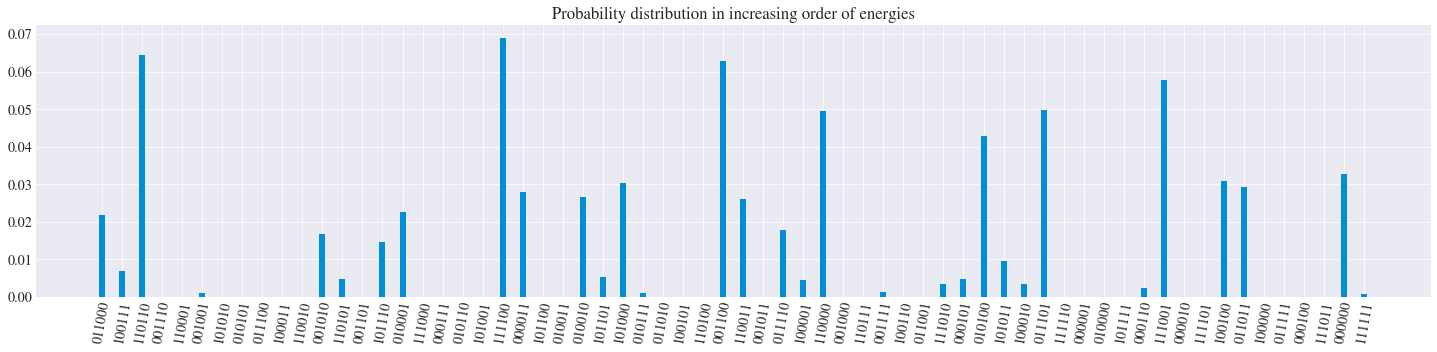

In [19]:
plot_counts(sort_counts_increasing_energy(cost_hamil, backend_obj.probability_dict(variate_params_clustered)))

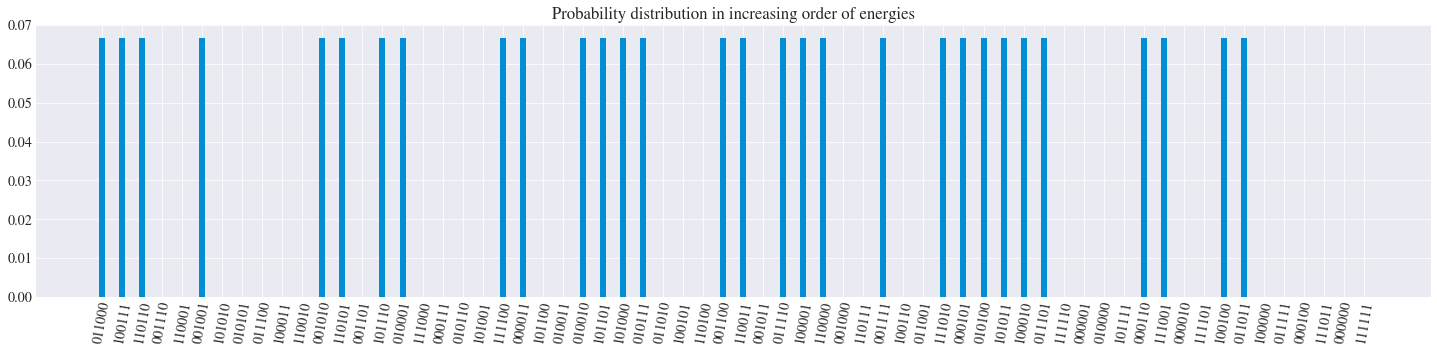

In [18]:
sorted_dicke_probs = sort_counts_increasing_energy(cost_hamil,qaoa_probabilities(prepend_state_2+prepend_state_4))
plot_counts(sorted_dicke_probs)

## Training QAOA with qiskit statevector backend

In [116]:
p=5
circuit_params = QAOACircuitParams(cost_hamil, mixer_hamil_xy, p=p)

In [136]:
max_std_dev=1
variate_params_clustered = create_qaoa_variational_params(circuit_params,'clustered','rand',max_std_dev = max_std_dev)
variate_params_standard = create_qaoa_variational_params(circuit_params,'standard','ramp')

In [118]:
# prepend_state = None
prepend_state = dicke_wavefunction(5,n_qubits = cost_prob.asdict()['n'])
init_hadamard = True if prepend_state is None else False

In [153]:
# device = create_device('local','vectorized')
device = create_device('local','qiskit.statevector_simulator')
backend_obj = get_qaoa_backend(circuit_params,device,prepend_state=prepend_state,init_hadamard=init_hadamard)

ValueError: The backend returned an error: Please use the shot-based simulator for simulations with cvar_alpha < 1

In [120]:
prob_dict = backend_obj.probability_dict(variate_params_standard)

In [121]:
sorted_prob = sort_counts_increasing_energy(cost_hamil, prob_dict)

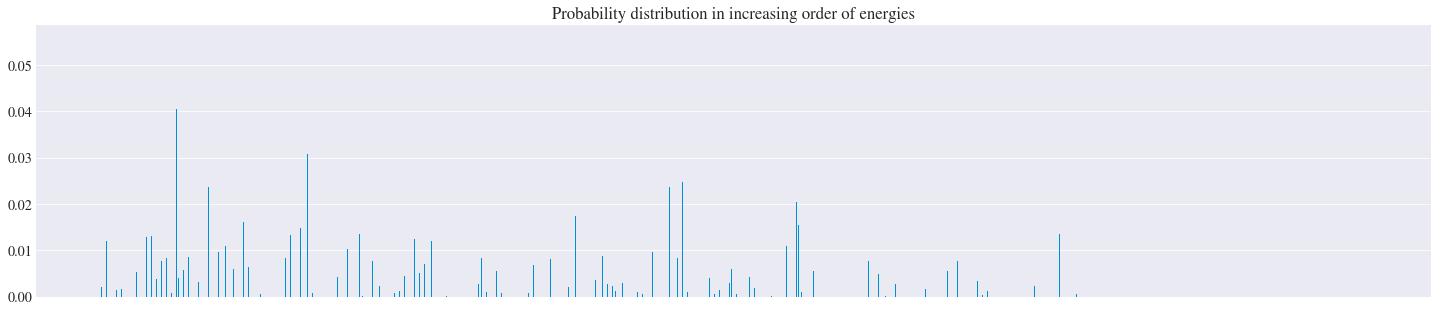

In [122]:
plot_counts(sorted_prob,show_xticks=False)

In [139]:
optimizer_dict = {'method': 'nelder-mead', 'maxiter': 4000}

In [140]:
optimizer_obj_standard = get_optimizer(backend_obj, variate_params_standard, optimizer_dict)
optimizer_obj_clustered = get_optimizer(backend_obj, variate_params_clustered, optimizer_dict)

In [125]:
optimizer_obj_standard
optimizer_obj_clustered

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAQiskitBackendStatevecSimulator 
Method: NELDER-MEAD with Max Iterations: 2000

In [144]:
%%time
optimizer_obj_standard()

CPU times: user 19min 42s, sys: 2min 55s, total: 22min 37s
Wall time: 6min 27s


Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAQiskitBackendStatevecSimulator 
Method: NELDER-MEAD with Max Iterations: 4000

In [141]:
%%time
optimizer_obj_clustered()

/Users/vishal/opt/anaconda3/envs/openqaoa_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/vishal/opt/anaconda3/envs/openqaoa_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 1h 31min 4s, sys: 10min 56s, total: 1h 42min 1s
Wall time: 1h 9min 10s


Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAQiskitBackendStatevecSimulator 
Method: NELDER-MEAD with Max Iterations: 4000

In [145]:
cost_history_clustered = optimizer_obj_clustered.results_information()['cost progress list']

In [146]:
cost_history_standard = optimizer_obj_standard.results_information()['cost progress list']

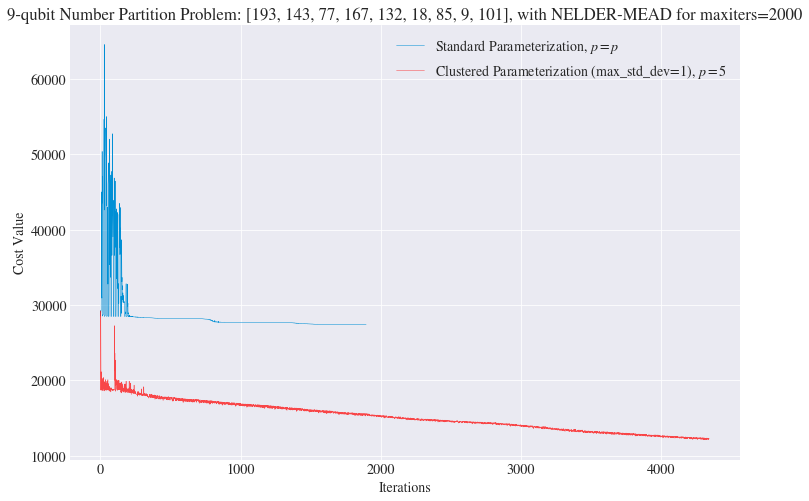

In [147]:
plt.plot(cost_history_standard,label='Standard Parameterization, $p={p}$',lw=0.5)
plt.plot(cost_history_clustered, color='red',label=f'Clustered Parameterization (max_std_dev={max_std_dev}), $p={p}$',lw=0.5,alpha=0.7)
# plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Cost Value')
plt.legend();
plt.title(f'9-qubit Number Partition Problem: {nums}, with NELDER-MEAD for maxiters=2000');
# plt.savefig(f'images/9-qubit Number Partition Problem: {nums}.pdf')

In [148]:
# optimizer_obj_clustered.results_information()['best param']

In [149]:
variate_params_standard.update_from_raw(optimizer_obj_standard.results_information()['best param'])
variate_params_clustered.update_from_raw(optimizer_obj_clustered.results_information()['best param'])
counts_dict_clustered = qaoa_probabilities(backend_obj.wavefunction(variate_params_clustered))
counts_dict_standard = qaoa_probabilities(backend_obj.wavefunction(variate_params_standard))

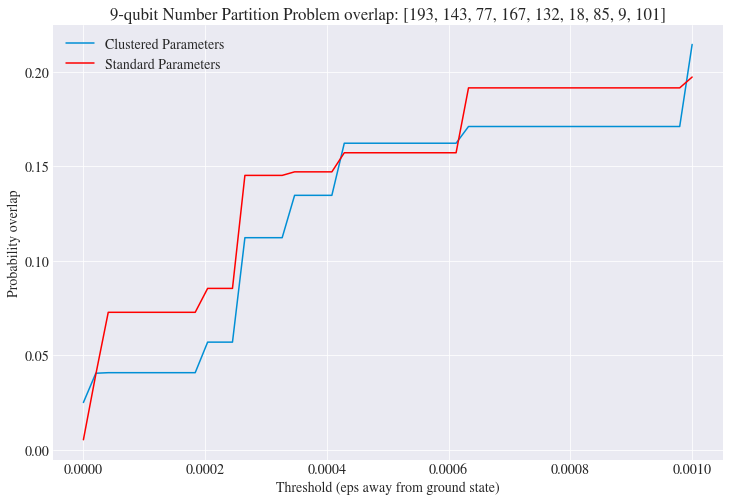

In [150]:
eps = np.linspace(0,0.001,50)
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_clustered) for ep in eps])
plt.plot(eps, [low_energy_states_overlap(cost_hamil, ep, counts_dict_standard) for ep in eps],color='red')
plt.legend(['Clustered Parameters','Standard Parameters'])
plt.xlabel('Threshold (eps away from ground state)')
plt.ylabel('Probability overlap')
plt.title(f'9-qubit Number Partition Problem overlap: {nums}');
# plt.savefig(f'images/9-qubit Number Partition Problem overlap: {nums}.pdf')

In [151]:
counts_dict_standard_sorted = sort_counts_increasing_energy(cost_hamil, counts_dict_standard)
counts_dict_clustered_sorted = sort_counts_increasing_energy(cost_hamil, counts_dict_clustered)

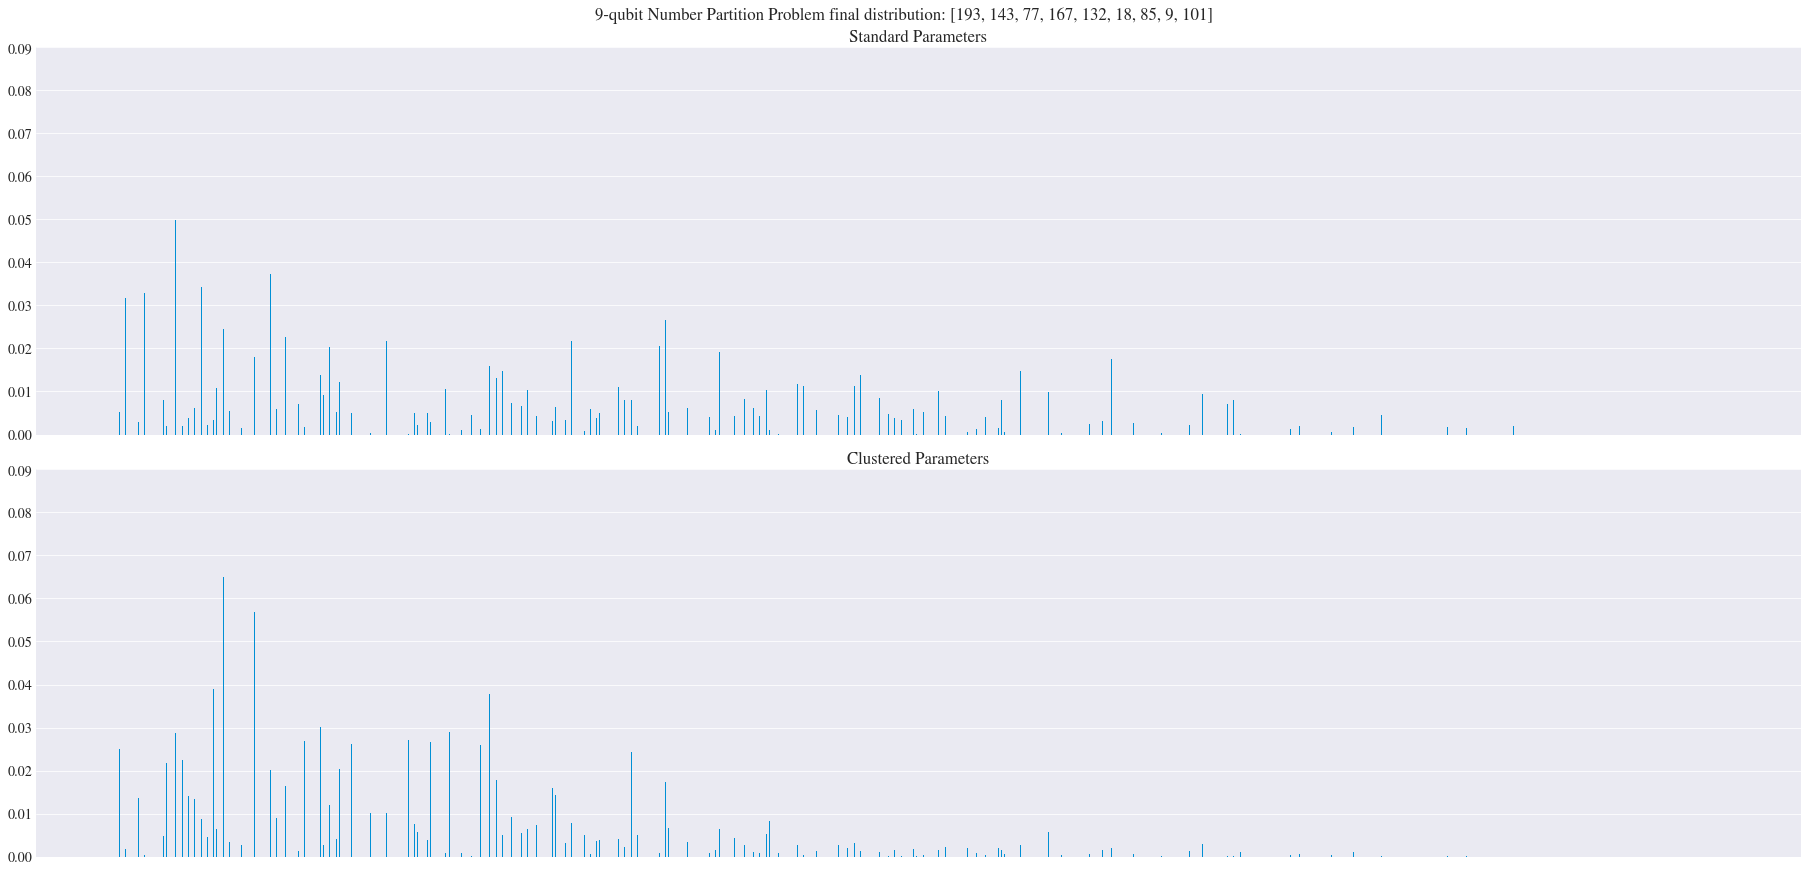

In [152]:
fig,axes = plt.subplots(2,1,figsize=(25,12),constrained_layout=True,sharey=True,sharex=True)
plot_counts(counts_dict_standard_sorted,False,axes[0])
plot_counts(counts_dict_clustered_sorted,False,axes[1])
axes[0].set_title('Standard Parameters')
axes[1].set_title('Clustered Parameters');
plt.suptitle(f'9-qubit Number Partition Problem final distribution: {nums}');
plt.ylim([0,0.09]);
# plt.savefig(f'images/9-qubit Number Partition Problem final energy distribution: {nums}.pdf')

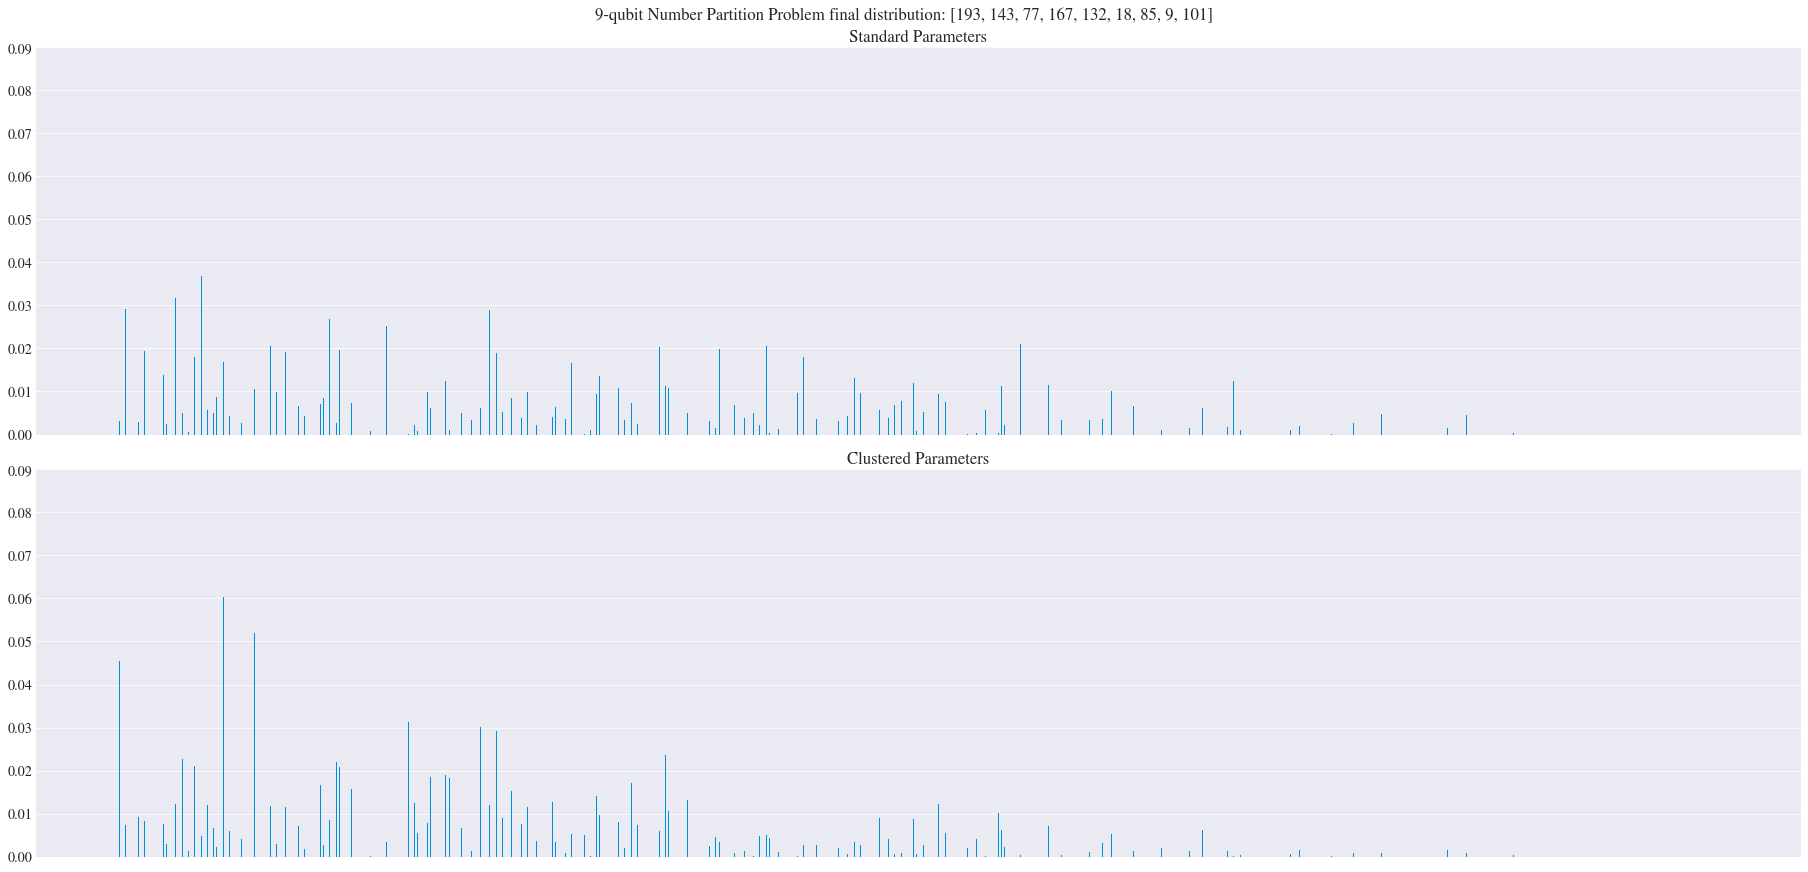

In [135]:
fig,axes = plt.subplots(2,1,figsize=(25,12),constrained_layout=True,sharey=True,sharex=True)
plot_counts(counts_dict_standard_sorted,False,axes[0])
plot_counts(counts_dict_clustered_sorted,False,axes[1])
axes[0].set_title('Standard Parameters')
axes[1].set_title('Clustered Parameters');
plt.suptitle(f'9-qubit Number Partition Problem final distribution: {nums}');
plt.ylim([0,0.09]);
# plt.savefig(f'images/9-qubit Number Partition Problem final energy distribution: {nums}.pdf')